In [4]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from loguru import logger
from omegaconf import OmegaConf

# import warnings
# warnings.filterwarnings("ignore")

# Useful imports
import os
from pathlib import Path
import tempfile

import hydra

os.environ["NUPLAN_DATA_ROOT"] = "/home/phidch/Downloads/nuplan"
os.environ["NUPLAN_MAPS_ROOT"] = '/home/phidch/Downloads/nuplan/dataset/maps'
os.environ["NUPLAN_DB_FILES"] = '/home/phidch/Downloads/nuplan/nuplan-v1.1/mini'
os.environ["NUPLAN_MAP_VERSION"] = 'nuplan-maps-v1.0'
NUPLAN_DATA_ROOT = os.getenv('NUPLAN_DATA_ROOT', '~/Downloads/nuplan')
NUPLAN_MAPS_ROOT = os.getenv('NUPLAN_MAPS_ROOT', '~/Downloads/nuplan/dataset/maps')
NUPLAN_DB_FILES = os.getenv('NUPLAN_DB_FILES', '~/Downloads/nuplan/nuplan-v1.1/mini')
NUPLAN_MAP_VERSION = os.getenv('NUPLAN_MAP_VERSION', 'nuplan-maps-v1.0')


# Location of path with all training configs
CONFIG_PATH = 'nuplan-devkit/nuplan/planning/script/config/training'
CONFIG_NAME = 'default_training'

# Create a temporary directory to store the cache and experiment artifacts
SAVE_DIR = os.path.join('tmp' ,'tutorial_nuplan_framework')  # optionally replace with persistent dir
os.makedirs(SAVE_DIR, exist_ok=True)
EXPERIMENT = 'training_raster_experiment'
LOG_DIR = os.path.join(SAVE_DIR, EXPERIMENT)
os.makedirs(LOG_DIR, exist_ok=True)

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration 
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'group={str(SAVE_DIR)}',
    f'cache.cache_path={str(SAVE_DIR)}/cache',
    f'experiment_name={EXPERIMENT}',
    'py_func=cache',
    '+training=training_raster_model',  # raster model that consumes ego, agents and map raster layers and regresses the ego's trajectory
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    'scenario_filter.limit_total_scenarios=500',  # Choose 500 scenarios to train with
    'lightning.trainer.params.accelerator=ddp_spawn',  # ddp is not allowed in interactive environment, using ddp_spawn instead - this can bottleneck the data pipeline, it is recommended to run training outside the notebook
    'lightning.trainer.params.max_epochs=30',
    'data_loader.params.batch_size=32',
    'data_loader.params.num_workers=8',

    'cache.cleanup_cache=True', 

    'worker=single_machine_thread_pool'
])


# cfg.splitter = 1
# cfg.scenario_builder.scenario_mapping.scenario_map = 1
# logger.info(OmegaConf.to_yaml(cfg))

# from nuplan.planning.script.run_training import main as main_train

# main_train(cfg)


from nuplan.planning.script.builders.utils.utils_config import update_config_for_training
from nuplan.planning.script.builders.folder_builder import build_training_experiment_folder
from nuplan.planning.script.builders.worker_pool_builder import build_worker

update_config_for_training(cfg)
# print(cfg.worker)
# build_training_experiment_folder(cfg)

worker = build_worker(cfg)
# print(worker.number_of_threads)

# from nuplan.planning.training.experiments.training import build_training_engine

# engine = build_training_engine(cfg, worker)
# print(type(engine.datamodule._train_set))


from nuplan.planning.script.builders.model_builder import build_torch_module_wrapper
from nuplan.planning.script.builders.training_builder import build_lightning_datamodule


torch_module_wrapper = build_torch_module_wrapper(cfg.model)
# print(type(torch_module_wrapper))
# feature_builders = torch_module_wrapper.get_list_of_required_feature()
# target_builders = torch_module_wrapper.get_list_of_computed_target()
# print(target_builders)

datamodule = build_lightning_datamodule(cfg, worker, torch_module_wrapper)
datamodule.setup(stage='fit')

train_dataloader = datamodule.train_dataloader()
print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [6]:
data = next(iter(train_dataloader))

In [8]:
print(data[0]['raster'].data.shape)

torch.Size([32, 4, 224, 224])


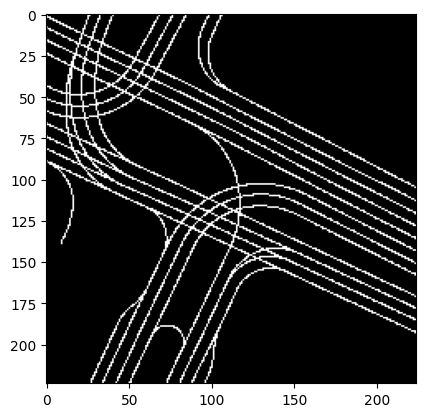

In [21]:
tmp = data[0]['raster'].baseline_paths_layer.numpy()
plt.imshow(tmp[2,:,:], cmap='gray')

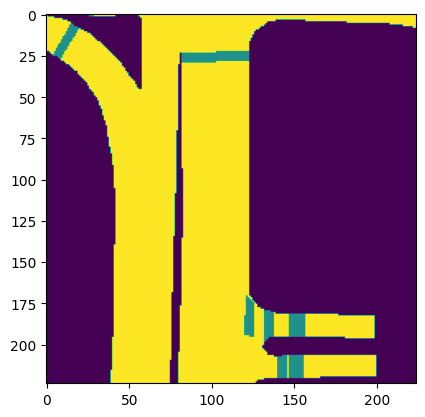

In [11]:
tmp = data[0]['raster'].roadmap_layer.numpy()

# tmp = (tmp*255).astype(np.uint8)
# for num in tmp.flatten():
#     if num not in [0, 255,127]:
#         print(num)

plt.imshow(tmp[0,:,:])

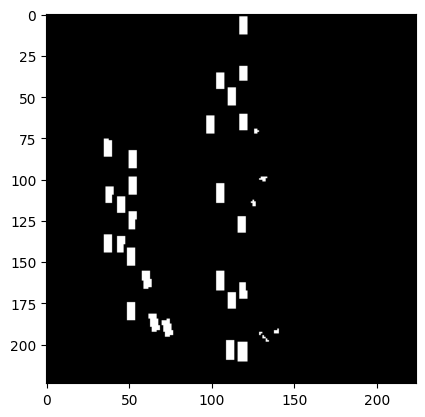

In [12]:
tmp = data[0]['raster'].agents_layer.squeeze(dim=1).numpy()
plt.imshow(tmp[1,:,:], cmap='gray')

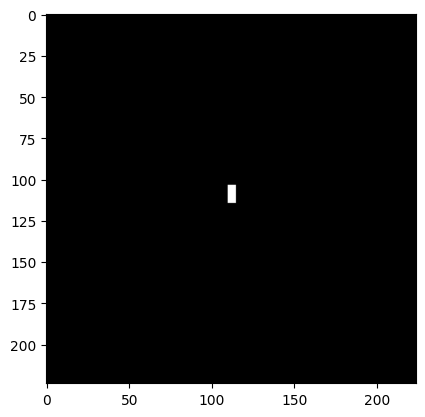

In [13]:
tmp = data[0]['raster'].ego_layer.squeeze(dim=1).numpy()
plt.imshow(tmp[0,:,:], cmap='gray')

In [14]:
xy = data[1]['trajectory'].xy[0]
print(xy)
xy = data[1]['trajectory'].xy[1]
print(xy)

tensor([[ 2.1616e-06, -7.7115e-06],
        [-1.5104e-05, -3.6965e-05],
        [-7.4599e-07, -6.9707e-05],
        [ 2.1665e-05, -9.2114e-05],
        [ 7.7686e-05, -8.6709e-05],
        [ 2.5770e-05, -5.0612e-05],
        [ 3.0636e-06, -3.2571e-05],
        [-5.7649e-06, -5.0697e-05],
        [-7.2075e-06, -1.0540e-05],
        [-3.1370e-05, -4.0140e-05],
        [-5.3377e-05, -6.6029e-05],
        [-1.4292e-05, -1.2234e-05],
        [ 3.7280e-05, -2.4977e-05],
        [-3.5024e-05, -5.2596e-05],
        [-3.6418e-05, -6.4867e-05],
        [-2.5225e-05, -6.9442e-05]])
tensor([[ 4.7462e+00, -2.8313e-03],
        [ 9.4286e+00, -1.6616e-02],
        [ 1.4080e+01, -3.3319e-02],
        [ 1.8876e+01, -4.6220e-02],
        [ 2.3957e+01, -4.3437e-02],
        [ 2.9364e+01, -4.1896e-02],
        [ 3.5079e+01, -2.1241e-02],
        [ 4.0867e+01,  4.0532e-02],
        [ 4.6628e+01,  1.2397e-01],
        [ 5.2465e+01,  2.3030e-01],
        [ 5.8416e+01,  3.3762e-01],
        [ 6.4394e+01,  4.57

In [15]:
data[1]['trajectory'].numpy_position_x[0, :]

array([ 2.1615997e-06, -1.5103724e-05, -7.4598938e-07,  2.1664891e-05,
        7.7685807e-05,  2.5769696e-05,  3.0635856e-06, -5.7648867e-06,
       -7.2075054e-06, -3.1369738e-05, -5.3377356e-05, -1.4291611e-05,
        3.7280377e-05, -3.5023782e-05, -3.6417507e-05, -2.5225338e-05],
      dtype=float32)

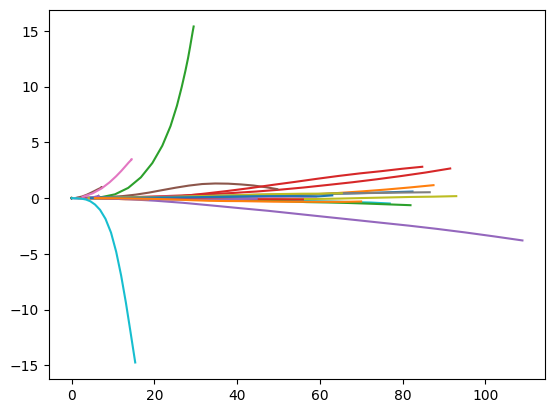

In [16]:
for i in range(len(data[1]['trajectory'].xy)):
    xy = data[1]['trajectory'].xy[i]
    x = xy[:, 0].numpy()
    y = xy[:, 1].numpy()
    # print(xy)
    plt.plot(x, y)

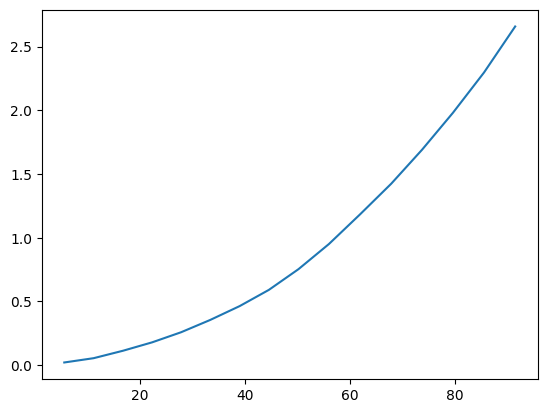

In [17]:
xy = data[1]['trajectory'].xy[3]
x = xy[:, 0].numpy()
y = xy[:, 1].numpy()
# print(xy)
plt.plot(x, y)

In [19]:
import cv2

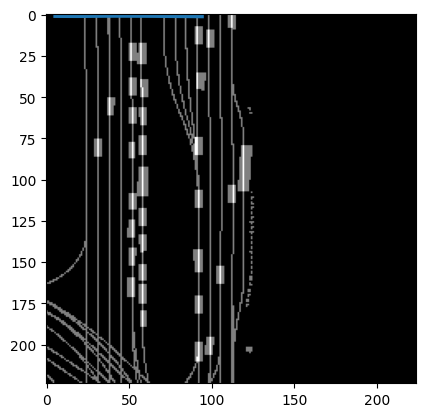

In [20]:
id = 18

tmp1 = data[0]['raster'].ego_layer.squeeze(dim=1).numpy()
tmp2 = data[0]['raster'].baseline_paths_layer.numpy()
# tmp = (tmp1.astype(int) + tmp2.astype(int)).astype(np.uint8)
tmp = cv2.add(tmp1, tmp2)
tmp3 = data[0]['raster'].agents_layer.squeeze(dim=1).numpy()
tmp = cv2.add(tmp, tmp3)
plt.imshow(tmp[id,:,:], cmap='gray')

xy = data[1]['trajectory'].xy[id]
x = xy[:, 0].numpy()
y = xy[:, 1].numpy()
# print(xy)
plt.plot(x, y, linewidth=5)